#### TabNet base and cross val model for inpData

In [33]:
import pandas as pd
import numpy  as np
import os
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
#from libdl.dl import dl

from pytorch_tabnet.tab_model import TabNetRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
pd.set_option('display.max_columns',9999)
%matplotlib inline

#### Loading training data set

In [34]:
path = "path to files directory"

file1= pd.read_csv(os.path.join(path,"inpData.csv"))
file1 = file1.iloc[:,3:len(file1.columns)] ## removing Region column
#file1.shape

file1.sample(5)

,las,soda,silicate,water_hardness,Mannaway_4T,Xpect_1000T,Savinase_16T,Stainzyme_12T,Celluclean,Lipex__100T,stains,response,stains_le
722,9,25.0,10,350,0.00,0.02,0.0,0.0,0.0,0.0,CS28,31.96,7
5959,0,25.0,0,350,0.00,0.00,0.0,0.0,0.0,0.0,WFK20PF,39.05,20
12363,9,25.0,0,350,0.00,0.00,0.0,0.0,0.0,0.0,WFK80A,65.30,21
655,18,25.0,10,150,0.05,0.00,0.0,0.0,0.0,0.0,CS28,32.14,7
11361,9,25.0,10,350,0.00,0.00,0.3,0.0,0.0,0.0,PCN01,77.25,16


#### processing categorical data

In [35]:
categorical_columns = []
categorical_dims =  {}
for col in file1.columns[file1.dtypes == object]:
    print(col, file1[col].nunique())
    l_enc = LabelEncoder()
  #  train_data[col] = train_data[col].fillna("VV_likely")
    file1[col] = l_enc.fit_transform(file1[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

#for col in train_data.columns[train_data.dtypes == 'float64']:
#    train_data.fillna(train_data.loc[train_data.index, col].mean(), inplace=True)




stains 22


#### Train Test Split

In [36]:
#spliting data into training and validation set ()
train_data, test_data = train_test_split(file1, test_size=0.2, random_state = 42) 
print("size of train_data = ", train_data.shape, "| size of test_data = ", test_data.shape)

size of train_data =  (10217, 13) | size of test_data =  (2555, 13)


#### Defining parameters

In [44]:
features = ['las', 'soda', 'silicate', 'water_hardness', 'Mannaway_4T',
       'Xpect_1000T', 'Savinase_16T', 'Stainzyme_12T', 'Celluclean',
       'Lipex__100T','stains']#[ col for col in train_data.columns if col not in [response]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : here just a random choice
cat_emb_dim = [5]  #watchout, match with cat_dims

cat_dims

[22]

Device used : cpu


In [46]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

### Train/Test (validation data) features and labels

X_train      = train_data[features].values                   #features
y_train      = train_data["response"].values.reshape(-1, 1)  #lables
X_valid = test_data[features].values
y_valid = test_data["response"].values.reshape(-1, 1)

## Setting max_epochs
max_epochs = 1000 if not os.getenv("CI", False) else 2

## model fitting
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=30,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

plt.plot(clf.history['loss'])

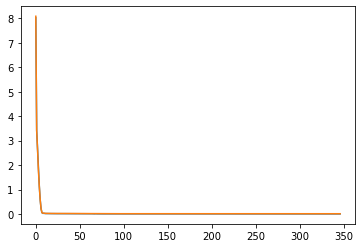

In [50]:
plt.plot(clf.history['train_rmsle'])
plt.plot(clf.history['valid_rmsle'])

### Feature of importance

<AxesSubplot:>

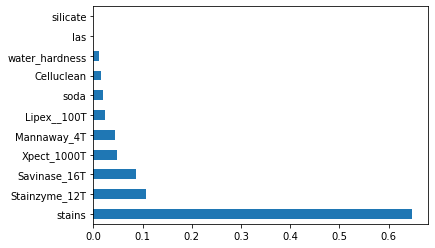

In [51]:
clf.feature_importances_
feat_importances = pd.Series(clf.feature_importances_, index=features)
feat_importances.nlargest(20).plot(kind='barh')

#### Load external test data 

In [54]:
ext_val = pd.read_csv(os.path.join(path,"nzin_emll_p2_test.csv"))
ext_val = ext_val.iloc[:,3:len(ext_val.columns)] ## removing Region column
#file1.shape

ext_val.sample(5)


## processing categorical data i.e. stains (ideally this can be run with stains_le)
categorical_columns2 = []
categorical_dims2 =  {}
for col in ext_val.columns[ext_val.dtypes == object]:
    print(col, ext_val[col].nunique())
    l_enc = LabelEncoder()
  #  train_data[col] = train_data[col].fillna("VV_likely")
    ext_val[col] = l_enc.fit_transform(ext_val[col].values)
    categorical_columns2.append(col)
    categorical_dims2[col] = len(l_enc.classes_)




X_ext_val = ext_val[features].values
y_ext_val = ext_val["response"].values.reshape(-1, 1)

stains 22


In [55]:
preds = clf.predict(X_ext_val)

y_true = y_ext_val

test_score = mean_squared_error(y_pred=preds, y_true=y_true)

print(f"BEST VALID SCORE FOR  : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR  : {test_score}")

BEST VALID SCORE FOR  : 7.93595071258747
FINAL TEST SCORE FOR  : 8.68269063343675


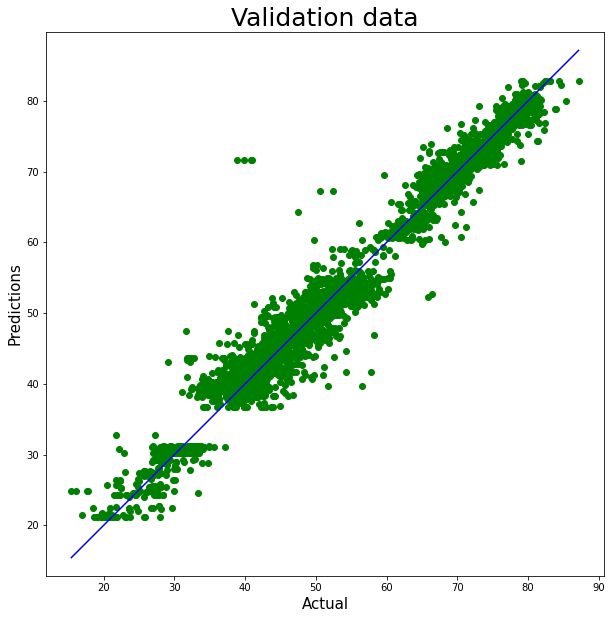

In [56]:

plt.figure(figsize=(10,10))
plt.scatter(y_true,preds, c='green')
#plt.yscale('log')
#plt.xscale('log')

p1_valid = max(max(preds), max(y_true))
p2_valid = min(min(preds), min(y_true))
plt.plot([p1_valid, p2_valid], [p1_valid, p2_valid], 'b-')

plt.title("Validation data", fontsize=25)
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')

plt.show()

###### Check with cross validation